# Filtering digital signals

In this notebook it is demonstrated how we can filter data in python. The following topics a demonstrated

1. [Simple filter example](#simple_filter_example)
2. [Band-pass filtering a noisy signal with multiple harmonics](#band_pass_harmonics)
3. [Low-pass filtering a noisy signal with multiple harmonics](#low_pass_harmonics)
4. [High-pass filtering a noisy signal with multiple harmonics](#high_pass_harmonics)
5. [Band-pass filtering a real MRU Roll signal](#band_pass_mru_roll)
6. [Filtering a more difficult input signal](#band_pass_hz3_difficult)
7. [Conclusions](#conclusions)

<a id='simple_filter_example'></a>

## A simple filter example

#### Some background information

In the signal processing tool box three base filters have been implemented: 
1. Ideal block filter (*bandpass_block_filter*, equivalent to the Matlab *band_pass2* filter by RvD) 
2. Kaiser filter (*kaiser_bandpass_filter*)
3. Butterworth filter (*butter_bandpass_filter*). 

All filters need at least a low or a high cut-off frequency as an input argument. In case only a low cut off frequency is passed, all three filters will behave as high-pass filter (as only the frequencies below f_cut_low are suppressed), whereas in case only a high cut off frequency is passed, all filters will behave as a low pass-filter (as only the frequencies above the f_cut_high are suppressed). In case both the low and high cut-off frequency are given, all filters will behave as a band pass filter. The cut off frequencies are given in Hz. Next to at least one cut-off frequency, another mandotary argument is the sample frequency *f_sample*, which is also given in Hz.

The *kaiser_bandpass_filter* and *butter_bandpass_filter* are in fact front ends to the *scipy* filters. In order to use the scipy filter quite some steps are required to calculate the filter coefficients. The implementations in this ** package take care of that and then call *scipy* filters. On top of the base filters an extra front end is defined, *filter_signal*, which receives the same input arguments as all three filtered mentioned above, plus an argument *filter_type*. Using this function we can pick which filter we want to use: *kaiser*, *block* or *butterworth*. The default choice is *kaiser*.

#### Filter a sine wave with noise: simple example
Let's have a look at a very simple example on how to filter a sine wave with some noice to retrieve the sine wave. We have to start with loading all the modules required.


In [5]:
import os
from numpy import (pi, sin, linspace, random)
import pandas as pd
from scipy.signal import (freqz, welch)
import matplotlib.pyplot as plt
import seaborn
import funcy

# load the modules
from signal_filters.filters import filter_signal
from signal_filters.utils import (SignalGenerator, get_peaks)

seaborn.set("notebook")


Now let's create a simple sine wave with noise and filter it so see how we can use *filter_signal*

In [6]:
T = 10  # peak period of 10 s give peak frequency of 0.1 Hz. Set f_cut_low and f_cut_high at resp 0.08  Hz and 0.12 Hz
f_peak = 1 / T
total_time = 1000
f_sample = 10  # sample frequency we put at 10 Hz
n_points = total_time * f_sample
A = 1.0
ap = 0.2 * A
time = linspace(0, total_time, num=n_points, endpoint=False)

# create the signal
y_original = sin(2 * pi * time / T)
y_noise = random.normal(scale=ap, size=y_original.size) 
y_total = y_original + y_noise

# filter the signal to get the sine but putting the limits around the peak frequency
y_sine_filtered = filter_signal(y_total, f_cut_low=0.08, f_cut_high=.12, f_sampling=f_sample)

At this point, we have filtered the signal using a Kaiser band pass filter. We can now calculate the power-spectral-densities of the time series

In [7]:
# get the spectral densities for the original, total, and recovered
ff, psd_original = welch(y_original, fs=f_sample, nperseg=2048)
ff, psd_total = welch(y_total, fs=f_sample, nperseg=2048)
ff, psd_filtered = welch(y_sine_filtered, fs=f_sample, nperseg=2048)

We can do the plotting to get some confidence in the results. 

found peak [0.09765625] with values [50.95474674]


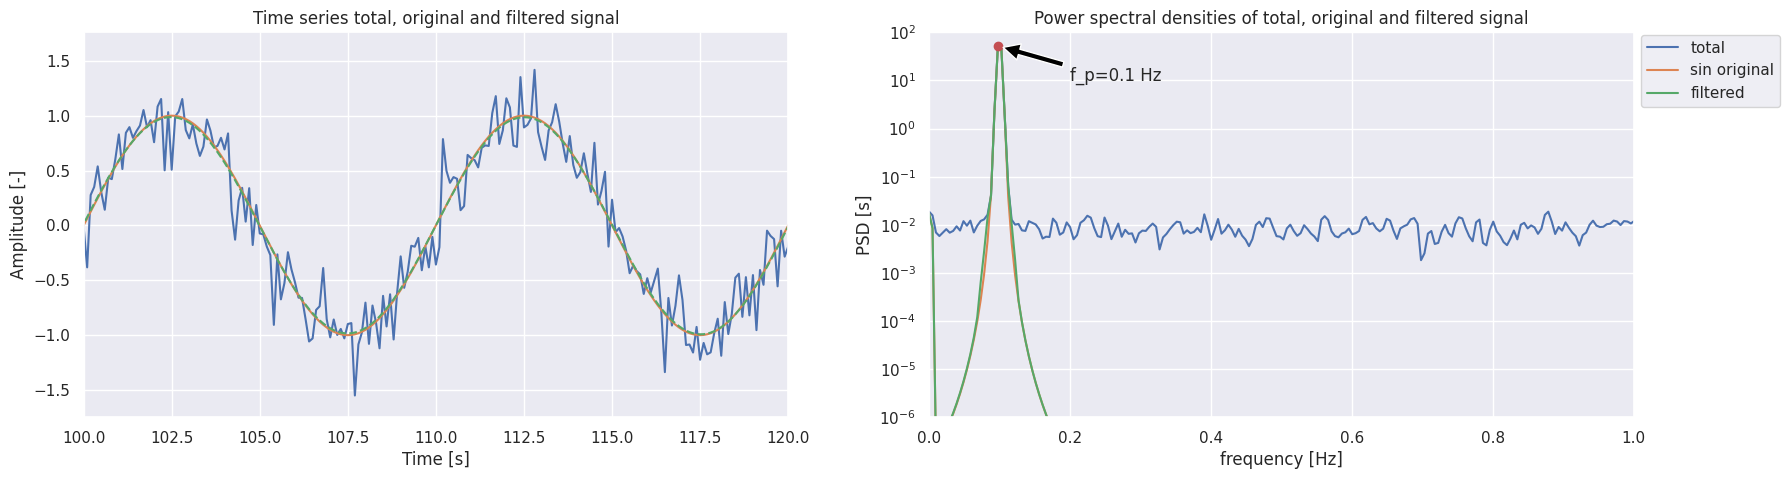

In [8]:
fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(20,5))

# create the plot at the left with the time series
axis[0].plot(time, y_total, label="total")
axis[0].plot(time, y_original, label="sin original")
axis[0].plot(time, y_sine_filtered, "--", label="filtered")
axis[0].set_xlim(100, 120) # only show two periods a bit away from time zero
axis[0].set_xlabel("Time [s]")
axis[0].set_ylabel("Amplitude [-]")
axis[0].set_title("Time series total, original and filtered signal")

# create the plot at the right with the Power spectral densities
axis[1].plot(ff, psd_total, label="total")
axis[1].plot(ff, psd_original, label="sin original")
axis[1].plot(ff, psd_filtered, label="filtered")
axis[1].set_xlabel("frequency [Hz]")
axis[1].set_ylabel("PSD [s]")
axis[1].semilogy()
axis[1].set_xlim(0,1)
axis[1].set_ylim(1e-6,100)
fp, vp = get_peaks(ff, psd_filtered, max_number_of_peaks=1)
print("found peak {} with values {}".format(fp, vp))
axis[1].plot(fp, vp, "or")
axis[1].annotate("f_p={} Hz".format(f_peak), xy=(1/T, psd_filtered.max()), xytext=(2/T, 10),   
                 arrowprops=dict(facecolor='black', shrink=0.05))
axis[1].set_title("Power spectral densities of total, original and filtered signal")
axis[1].legend(loc='center left', bbox_to_anchor=(1.0, 0.9))
plt.show()

As you can see, the original sin wave is recovered very well. The only catch for the Kaiser filter is that our time signal needs to be at least longer than the number of filter-coefficients. The number of coefficients increases when we decrease the filter edge width (controlled by the *f_width_edge* argument), i.e. the transition width from the stop band to the pass band. The sharper this edge, the wider the filter spectrum and the better we approach an ideal band pass filter. To be sure that we use enough point we have picked quite a long time series with in total 10,000 samples, which is definitly long enough for this case.

<a id='band_pass_harmonics'></a>

## Band pass filtering a noisy signal with multiple harmonics

We are going to create an artificial signal with 2 harmonics and some noise. Then we will use the available filters to get the low, high, and band pass filtered signal. 

This time we are going to use the *SignalGenerator* from the *signal_processing.utils* module as this allows use to easily access the indivdidual components of the harmonic signal with noise: each component is stored in the *data_frame* attribute pandas DataFrame such that we can plot them later. Let's make a signal with 3 harmonic components at 0.033 Hz (T=30 s), 0.071 Hz (T=14 s), and 0.83 Hz (T=1.2 s) plus some noise

In [9]:
time_length = 1800 # 30 minutes sample
f_sample = 25 # 25 Hz 
signal = SignalGenerator(time_length=time_length, sample_frequency=f_sample)
signal.add_component(key="f_low", amplitude=1.5, period=30.0, phase_shift=0.11)
signal.add_component(key="f_high", amplitude=1.8, period=1.2, phase_shift=1.5)
signal.add_component(key="f_zero", amplitude=1, period=14.0)
signal.add_component(key="noise", amplitude=0.8, signal_type="random_normal")
signal.report_components()
signal.generate()
signal.info()

              Total         f_low        f_high        f_zero         noise
count  45001.000000  45001.000000  45001.000000  45001.000000  45001.000000
mean      -0.004195      0.000033      0.000003     -0.000536     -0.003695
std        1.971636      1.060683      1.272792      0.707292      0.797418
min       -6.493179     -1.499999     -1.798964     -1.000000     -3.017565
25%       -1.401942     -1.059596     -1.249111     -0.703926     -0.543214
50%       -0.001196      0.004646      0.127327     -0.008976     -0.003774
75%        1.388634      1.059596      1.249111      0.703926      0.531774
max        6.716382      1.499999      1.798964      1.000000      3.415931


To get an impression of the time series we show the first 20 seconds from the t_start:

/tmp/ipykernel_90755/2718485875.py:4: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  data_df[t_start_plot:t_end_plot].plot(y=["Total"])


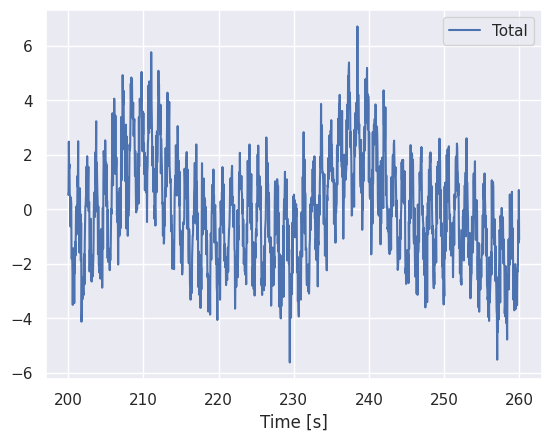

In [10]:
data_df = signal.data_frame
t_start_plot = 200
t_end_plot = t_start_plot + 60
data_df[t_start_plot:t_end_plot].plot(y=["Total"])
plt.show()

In order to retrieve the harmonic with a period of 14 s we are going to band pass filter the signal with a low and high cut off 0.05 Hz and 1 Hz respectively. We do this for the 3 available base filters: *butterworth*, *block*, and *kaiser*. Since we are supplying both the low and high cut off frequency, automatically the band pass filter will be used. The resulting band pass filtered signal is stored in the same data frame *data_df* with the column names BP_*filtername*

In [11]:
f_cut_low = 0.05  # in Hz
f_cut_hig = 0.1   # in Hz
all_filters = ["butterworth", "block", "kaiser"]
bp_filter_columns = list()
for filter_type in all_filters:
    new_column_name = "_".join(["BP", filter_type])
    bp_filter_columns.append(new_column_name)
    
    data_df[new_column_name] = filter_signal(data_df["Total"].values, filter_type=filter_type, f_cut_low = f_cut_low, 
                                             f_cut_high = f_cut_hig, f_sampling = f_sample, order=3)
    print("Filtered signal {:20s} yields std of {:.4f} (compared to {:.4f})"
                "".format(filter_type, data_df[new_column_name].std(), data_df["f_zero"].std()))

Filtered signal butterworth          yields std of 0.7084 (compared to 0.7073)
Filtered signal block                yields std of 0.7102 (compared to 0.7073)
Filtered signal kaiser               yields std of 0.7067 (compared to 0.7073)


Note that we have just filter the signal with three different filters. The *filter_signal* function is just a front end
to the Butterworth, Block and Kaiser filter. The standard deviation is reported to be 0.7, while the 14 s period component had an amplitude of 1, which means its standard deviation is sqrt(2)/2 = 0.707. Close enough. 

We can now plot the result and compare it with the target signal which was stored by the *SignalGenerator* class in the column with its corresponding name *f_zero*

/tmp/ipykernel_90755/2404483307.py:2: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  data_df[t_start_plot:t_end_plot].plot(y=["Total"]+["f_zero"]+bp_filter_columns)


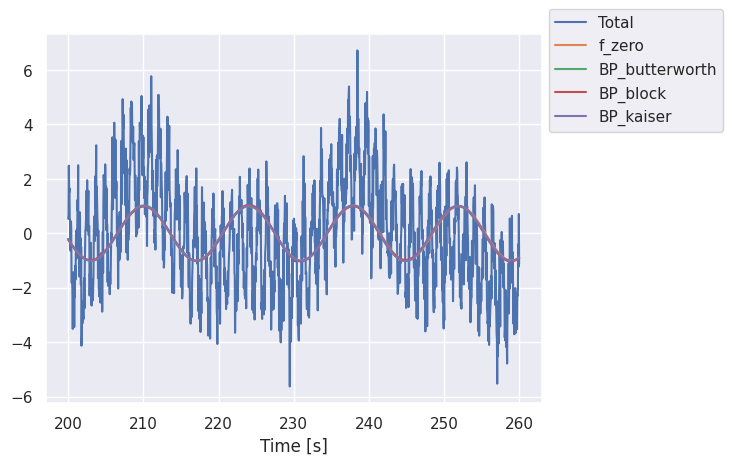

In [12]:
data_df = signal.data_frame
data_df[t_start_plot:t_end_plot].plot(y=["Total"]+["f_zero"]+bp_filter_columns)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.9))
plt.show()

As you can see, all of the filters (butterworth, block and kaiser) are able to retrieve the 14 s period component given by f_zero with a standard deviation very near to the theoretic standard deviation of the f_zero compomnent. Also the phase shift is zero for all filters as under the hood the *filtfilt* filter is used which takes care of the filter phase shift by applying the filter twice. 

As a next step we are going to compare the power spectral densities (PSD) of the filtered signal with the PSD of the original harmonic component *f_zero* component and the PSD of the total signal stored in the "Total" columns. We do that by looping over all the filter names and extra columns which we stored before in the data frame, calucatingn the PSD using Welch (from the *scipy.signal* module) and then store the result in a new data frame *psd_df*:

In [13]:
psd_df = None
peaks = dict()
for cnt, filter_type in enumerate(all_filters + ["f_zero", "Total"]):
    new_column_name = "_".join(["PSD", filter_type]) 
    if filter_type in all_filters:
        bp_column = bp_filter_columns[cnt]
    else:
        bp_column = filter_type
    ff, psd = welch(data_df[bp_column].values, f_sample, window="hann", nperseg=4096)
    if psd_df is None:
        psd_df = pd.DataFrame(index=ff, data=psd, columns=[new_column_name])
    else:
        psd_df[new_column_name] = psd
    fp, vp = get_peaks(ff, psd)
    print("Storing peak for filter {} : {} {}".format(filter_type, fp, vp))        
    peaks[filter_type] = (fp, vp)

Storing peak for filter butterworth : [0.07324219] [49.20634893]
Storing peak for filter block : [0.07324219] [49.20905715]
Storing peak for filter kaiser : [0.07324219] [49.00368515]
Storing peak for filter f_zero : [0.07324219] [48.70298899]
Storing peak for filter Total : [0.83618164 0.03051758 0.07324219] [133.06838825  93.26802737  49.20810314]


found peaks [0.83618164 0.03051758 0.07324219] with values [133.06838825  93.26802737  49.20810314]
Adding peak butterworth : [0.07324219]
Adding peak block : [0.07324219]
Adding peak kaiser : [0.07324219]


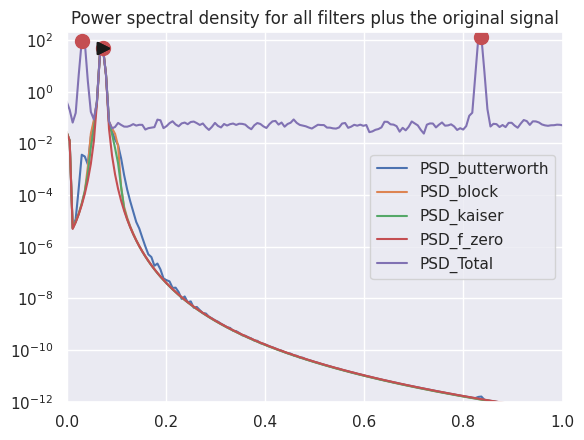

In [14]:
psd_df.plot()
# plt.semilogy()
plt.xlim(0,1)
plt.ylim(1e-12, 200)
print("found peaks {} with values {}".format(fp, vp))

# also add markers at the peak frequencies
plt.plot(peaks["Total"][0], peaks["Total"][1], "or", markersize=10)
for filter_type in all_filters:
    print("Adding peak {} : {}".format(filter_type, peaks[filter_type][0]))
    plt.plot(peaks[filter_type][0], peaks[filter_type][1], ">k", markersize=8)
    
plt.semilogy()
plt.title("Power spectral density for all filters plus the original signal")
plt.show()

The yellow line represents the spectrum of the total signal with three peaks at f_low=0.033 Hz, f_zero=0.072 Hz and f_high 0.83 Hz. The red dot indicates the theoretical location of the peak f_zero at 1/14 = 0.071 Hz which we want to retrieve with out band-pass filter.

All three filters are able to retrieve the peak frequency. The only catch is that we may need to tune both the Kaiser filter and the Butterworth filter with the *f_edge_width* input argument and the *order* argument, respectively. For the Kaiser filter, the smaller the *f_edge_width*, the better the frequencies out of the band range are suppressed, but also the more prone the filter gets to diverging results. For the Butterwordth filter, the higher the order, the better the frequency outside the band-range are suppressed, but also the more prone the filter gets to divergence. In this example for instance, the order=3 was chosen, which gives good results. For order=4 the filter diverges, for order=2 too many frequencies outside of the band range can be found. 

<a id='low_pass_harmonics'></a>

## Low pass filtering a noisy signal with multiple harmonics

In the example above we had a signal with harmonics at f_low = 0.033 Hz (the 30 s component), f_zero = 0.071 Hz (the 14 s component) and f_high = 0.83 Hz (the 1.2 s component) plus some noise distributed over all frequencies. In order to obtain the f_zero peak we have applied a band pass filter with the f_cut_low = 0.05 and f_cut_high = 0.1 such that all peaks except the f_zero were suppressed

In this example we want to obtain the low frequency peak at f_low = 0.033 Hz. This means that we need to shift the high cut off frequency to f_cut_high = 0.05. The low cut off frequency may be put to a value very close to zero in case we use the band pass filter again. However, if we don't specify the f_cut_low at all, the default value of None is assumed as default, which implies that we are going to turn the band pass filter into a low pass filter with a cut off frequency f_cut_high. 

Let's do that now


In [15]:
f_cut_hig = 0.05  # in Hz
lp_filter_columns = list()
for filter_type in all_filters:
    new_column_name = "_".join(["LP", filter_type])
    lp_filter_columns.append(new_column_name)
    data_df[new_column_name] = filter_signal(data_df["Total"].values, filter_type=filter_type,  
                                             f_cut_high = f_cut_hig, f_sampling = f_sample, order=4)
    print("Filtered signal {:20s} yields std of {:.4f} (compared to {:.4f})"
                "".format(filter_type, data_df[new_column_name].std(), data_df["f_low"].std()))

Filtered signal butterworth          yields std of 1.0202 (compared to 1.0607)
Filtered signal block                yields std of 1.0631 (compared to 1.0607)
Filtered signal kaiser               yields std of 1.0337 (compared to 1.0607)


/tmp/ipykernel_90755/1524119434.py:1: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  data_df[t_start_plot:t_end_plot].plot(y=["Total"]+["f_low"]+lp_filter_columns)


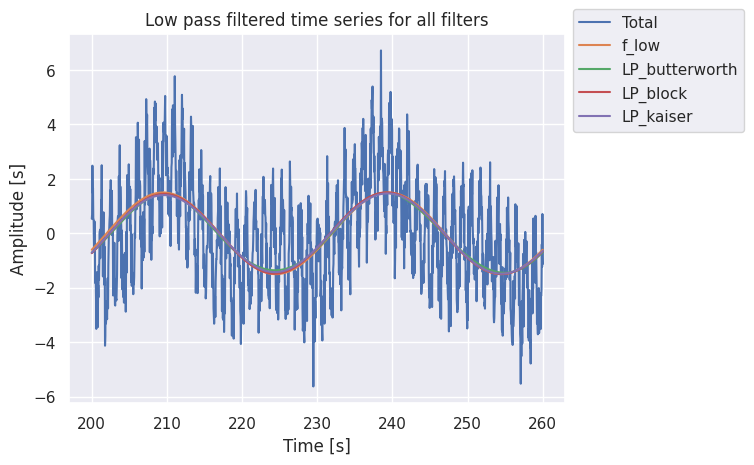

In [16]:
data_df[t_start_plot:t_end_plot].plot(y=["Total"]+["f_low"]+lp_filter_columns)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.9))
plt.title("Low pass filtered time series for all filters")
plt.ylabel("Amplitude [s]")
plt.show()

Again all base filter show more or less the same result. We can compare the PSD of the fitlered signal and compare it with the *f_low* harmonic and the total signal with noise:

In [17]:
psd_df = None
peaks_lp = dict()
for cnt, filter_type in enumerate(all_filters + ["f_low", "Total"]):
    new_column_name = "_".join(["PSD", filter_type]) 
    if filter_type in all_filters:
        lp_column = lp_filter_columns[cnt]
    else:
        lp_column = filter_type
    ff, psd = welch(data_df[lp_column].values, f_sample, window="hann", nperseg=4096)
    if psd_df is None:
        psd_df = pd.DataFrame(index=ff, data=psd, columns=[new_column_name])
    else:
        psd_df[new_column_name] = psd
    fp, vp = get_peaks(ff, psd)
    print("Storing peak for filter {} : {} {}".format(filter_type, fp, vp))
    peaks_lp[filter_type] = (fp, vp)


Storing peak for filter butterworth : [0.03051758] [86.38413907]
Storing peak for filter block : [0.03051758] [93.26400774]
Storing peak for filter kaiser : [0.03051758] [88.58933012]
Storing peak for filter f_low : [0.03051758] [93.02407032]
Storing peak for filter Total : [0.83618164 0.03051758 0.07324219] [133.06838825  93.26802737  49.20810314]


Adding peak butterworth     at [0.03051758] Hz
Adding peak block           at [0.03051758] Hz
Adding peak kaiser          at [0.03051758] Hz


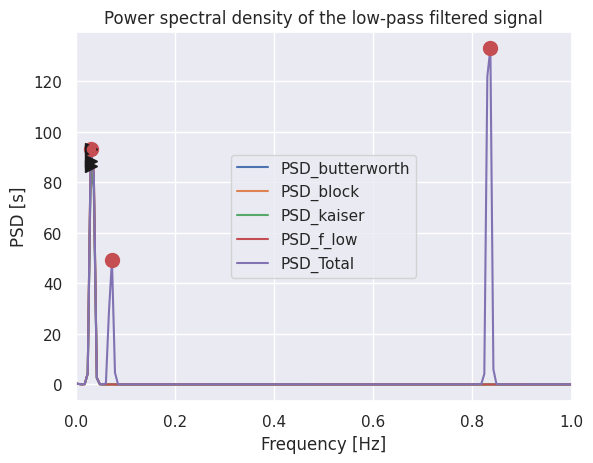

In [18]:
psd_df.plot()
# plt.semilogy()
plt.xlim(0,1)
# plt.ylim(1e-9, 10)
# also add markers at the peak frequencies
plt.plot(peaks_lp["Total"][0], peaks["Total"][1], "or", markersize=10)
for filter_type in all_filters:
    print("Adding peak {:15s} at {} Hz".format(filter_type, 
                                                  peaks_lp[filter_type][0]))
    plt.plot(peaks_lp[filter_type][0], peaks_lp[filter_type][1], ">k", markersize=8)
    
plt.plot(fp,vp, "or")
plt.title("Power spectral density of the low-pass filtered signal")
plt.xlabel("Frequency [Hz]")
plt.ylabel("PSD [s]")
plt.show()

It is demonstrated that also in the low-pass filterin mode all filters yield the same result.

<a id='high_pass_harmonics'></a>


## High pass filtering a noisy signal with multiple harmonics

Finally, in the series of harmonic signal filtering, we are going to extract the high-frequency component at 0.83  Hz + all the higher frequencies due to the noise contribution (since we are going to use a high-pass filter). Let's put the filter low cut off frequency at 0.8 Hz. Since we don't specify a high pass cut-off, it is automatically assumed we are in the high-pass filtering mode (i.e. all frequencies above the low cut-off frequency may pass).

In [19]:
f_cut_low = 0.8  # in Hz
hp_filter_columns = list()
for filter_type in all_filters:
    new_column_name = "_".join(["HP", filter_type])
    hp_filter_columns.append(new_column_name)
    data_df[new_column_name] = filter_signal(data_df["Total"].values, filter_type=filter_type,  
                                             f_cut_low=f_cut_low, f_sampling=f_sample, order=4)
    print("Filtered signal {:20s} yields std of {:.4f} (compared to {:.4f})"
                "".format(filter_type, data_df[new_column_name].std(), data_df["f_high"].std()))

Filtered signal butterworth          yields std of 1.0664 (compared to 1.2728)
Filtered signal block                yields std of 1.4886 (compared to 1.2728)
Filtered signal kaiser               yields std of 1.4884 (compared to 1.2728)


/tmp/ipykernel_90755/1790666327.py:1: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  data_df[t_start_plot:t_start_plot + 2].plot(y=["f_high"]+hp_filter_columns)


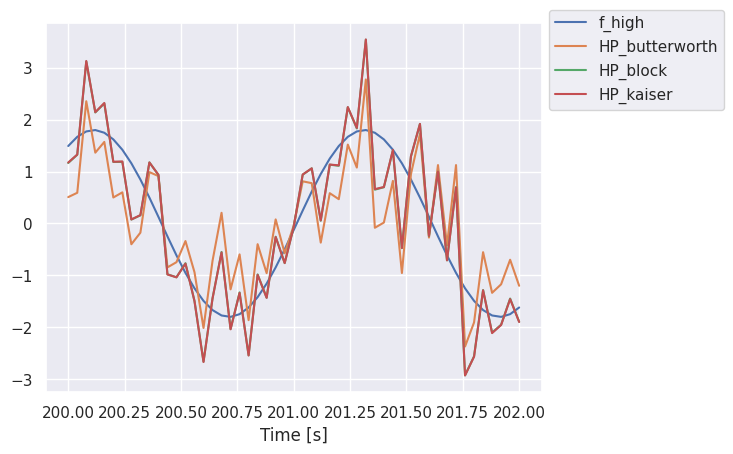

In [20]:
data_df[t_start_plot:t_start_plot + 2].plot(y=["f_high"]+hp_filter_columns)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.9))
plt.show()

This time the is some differente between the butterworth filter and the other two filters, although it is not much. Note that we can use the *order* input argument of the *filter_signal* function to change the behaviour of the *butter_worth* filter: higher orders lead to a sharper attenuation at the cut off frequency. It Kaiser and Block filter are virtually the same, which is not supressing: in the limit of *f_width_edge* -> 0 we Kaiser filter turns in to an ideal block filter. 

<a id='band_pass_mru_roll'></a>

## Band pass filtering a real MRU Roll signal

In this example we are going to supply the filters on a real data signal of the MRU of the roll component stored in a MDF file. Let's first import the data

In [21]:
# define the filename
file_name = "data/AMS_BALDER_110225T233000_UTC222959.mdf"
if not os.path.exists(file_name):
    file_name = os.path.join("..", file_name)
# read the data
print("Reading mdf file {}".format(file_name))
mdf_object = mdf.MDFParser(file_name, verbose=1, import_data=False, set_relative_time_column=True)
mdf_object.set_column_selection(filter_list=["MRU_Roll"], include_date_time=True)

mdf_object.import_data()

# show some information
mdf_object.data.info()
names = mdf_object.make_report(show_loaded_data_only=True)

data_df = mdf_object.data
data_df.set_index("time_r", inplace=True, drop=True)  # make the relative time (wrt the start) the index
data_df.index.name = "Time [s]"
delta_time = data_df.index[1] - data_df.index[0]
print("Found delta time of {} s".format(delta_time))

Reading mdf file ../data/AMS_BALDER_110225T233000_UTC222959.mdf


NameError: name 'mdf' is not defined

As a next step, we are going to filter the data with all three base filters with a cut off frequencies. Normal values would be 0.05 Hz (20  s) and 0.25 Hz (T=4 s), i.e. in the wave frequency range. However, this signal has a peak at 0.08 Hz, which we want to get out. So lets see if we can do that by picking the boundaries of the filter a bit tighter around 0.08 Hz, such as 0.06 and 0.09 Hz

In [18]:
f_cut_low = 0.06  # in Hz, i.e., remove a trend with a period longer than 20 s
f_cut_hig = 0.09  # in Hz i.e., remove the high frequencies with a period shorted than 4 s
print("filter f_low = {} Hz (T={} s)".format(f_cut_low, 1/f_cut_low))
print("filter f_hig = {} Hz (T={} s)".format(f_cut_hig, 1/f_cut_hig))
f_sample = 1 / delta_time
all_filters = ["butterworth", "block", "kaiser"]
bp_filter_columns = list()
for filter_type in all_filters:
    new_column_name = "_".join(["BP", filter_type])
    bp_filter_columns.append(new_column_name)
    
    with funcy.print_durations(filter_type):
        data_df[new_column_name] = filter_signal(data_df["MRU_Roll"].values,
                                                 filter_type=filter_type, 
                                                 f_cut_low=f_cut_low, 
                                                 f_cut_high=f_cut_hig, 
                                                 f_sampling=f_sample, 
                                                 order=3, 
                                                 f_width_edge=0.05, 
                                                 ripple_db=200)

Most significant difference for now is the calculation time for each filter. The Butterworth filter is extremely fast (3ms). The block filter take about 100 x longer, and the Kaiser filter is again 10 x slower than the block filter. It should be noted that the calculation time of the Kaiser filter depends on the stop band edge width and stop band, given by the *f_width_edge* and *ripple_db* parameters, respectively. 

We can again calculate the PSD's of the filtered signals + the original input signal for comparison

In [19]:
psd_df = None
peaks = dict()
for cnt, filter_type in enumerate(all_filters+["MRU_Roll"]):
    new_column_name = "_".join(["PSD", filter_type]) 
    if filter_type in all_filters:
        bp_column = bp_filter_columns[cnt]
    else:
        bp_column = filter_type
    ff, psd = welch(data_df[bp_column].values, f_sample, window="hann", nperseg=10000)
    if psd_df is None:
        psd_df = pd.DataFrame(index=ff, data=psd, columns=[new_column_name])
    else:
        psd_df[new_column_name] = psd
    
    fp, vp = get_peaks(ff, psd, max_number_of_peaks=5)
    print("Found peaks {:20s} at {}".format(filter_type, fp))
    peaks[filter_type] = (fp, vp)

data_df.info()


Now we are done with the filtering, we can plot the result:

In [20]:
fig, axis = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

for irow in range(2):
    data_df.plot(y=bp_filter_columns, ax=axis[irow][0])
    axis[irow][0].set_ylabel("Roll [deg]")
    axis[irow][0].set_title("Time series Roll signal with 3 filters")

    psd_df.plot(ax=axis[irow][1])
    axis[irow][1].set_xlim(0,0.2)
    # axis[1].set_ylim(1e-13,1e-4)
    axis[irow][1].set_xlabel("Frequency [Hz]")
    axis[irow][1].set_ylabel("PSD [deg s]")
    axis[irow][1].set_title("PSD of 3 filters + original ")
    #plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.9))
    
    
    
    if irow == 1:
        axis[irow][0].set_xlim(0, 200)
        axis[irow][1].semilogy()
        axis[irow][1].set_ylim(1e-15,1e-3)
    else:
        f_peaks, values = peaks["MRU_Roll"]
        axis[irow][1].plot(f_peaks, values, "or")
        for ii, fp in enumerate(f_peaks):
            axis[irow][1].annotate("{:.1g} Hz".format(fp), 
                                   xy=(fp, values[ii]), 
                                   xytext=(0,10),   
                                   ha="center",
                                   color="xkcd:blue",
                                   textcoords='offset points', xycoords="data")
        
plt.show()

All filters are able to remove the long scale motion at 0.003 Hz and als the small peak at 0.03 Hz. The resulting time series are on top of each other. Only the Kaiser filter take much more time to filter the signal, however, the calculation time is influenced by the the edge width and stop band. Nevertheless, because Kaiser is based on convolutions (and not FFT), it is inherently slower. Also, with this narrow band width the Kaiser filter seems to loose some energy of the bin. This effect does not play a role for a wider band width of the filter.

The Butterworth filter seem to perform well and has an exellent formance on the caculation time. However, with Butterworth you have to be carefull: if the order is to high the filter will blow up, so it needs some tuning

<a id='band_pass_hz3_difficult'></a>

## Filtering a more difficult input signal

In this last example it will be demonstrated that for more difficult signals using a block filter is not the best choise. For this first import a new file and get the accelerator output from the HZ3

In [21]:
# define the filename
file_name = "data/AMS_BALDER_160927T143000.mdf"
if not os.path.exists(file_name):
    file_name = os.path.join("..", file_name)
# read the data
print("Reading mdf file {}".format(file_name))
mdf_object = mdf.MDFParser(file_name, verbose=1, import_data=False, set_relative_time_column=True)
names, labels, groups = mdf_object.set_column_selection(filter_list=["BALDER", "HZ.*AX.*"], include_date_time=True)

# the column matching the pattern HZ.*AX* are stored in the names list. Keep the signal name for later reference
signal_name = names[0]
print("Found signal name of HZ.*AX: {}".format(signal_name))

# now do the actual import of the data
mdf_object.import_data()
# show some information
mdf_object.data.info()
names = mdf_object.make_report(show_loaded_data_only=True)

# create a link to the pandas dataframe and set the index equal to the relative time in seconds
data_df = mdf_object.data
data_df.set_index("time_r", inplace=True, drop=True)  # make the relative time (wrt the start) the index
data_df.index.name = "Time [s]"
delta_time = data_df.index[1] - data_df.index[0]
print("Found delta time of {} s".format(delta_time))

Now we are going to band-pass filter the signal to get the wave frequency part between 0.05 Hz and 0.25 Hz (ie waves with periods in the range of 4 to 20 seconds). 

In [22]:
f_cut_low = 0.05  # in Hz, i.e. remove trend with period longer than 20 s
f_cut_hig = 0.25  # in Hz i.e. remove high frequencies with period shorted than 4 s
print("filter f_low = {} Hz (T={} s)".format(f_cut_low, 1/f_cut_low))
print("filter f_hig = {} Hz (T={} s)".format(f_cut_hig, 1/f_cut_hig))
f_sample = 1 / delta_time
all_filters = ["mean", "butterworth", "kaiser", "block"]
bp_filter_columns = list()
for filter_type in all_filters:
    new_column_name = "_".join(["BP", filter_type])
    bp_filter_columns.append(new_column_name)
    
    with funcy.print_durations(filter_type) as t:
        data_df[new_column_name] = filter_signal(data_df[signal_name].values,
                                                 filter_type=filter_type, 
                                                 f_cut_low=f_cut_low, 
                                                 f_cut_high=f_cut_hig, 
                                                 f_sampling=f_sample, 
                                                 order=3, 
                                                 f_width_edge=0.05, 
                                                 ripple_db=200)

The mean filter was just included to obtain a reference signal around a mean of zero (because just the mean value is subtracted with the mean filter). Then, in the list of filter, you can see the butterworth is again extremely fast, our kaiser filter is significantly slower than butterworth (more than 1000 x ). The block filter is about 100 x slower than the Butterworth filter. 

As a next step get the power spectra of all the signals and get the main peaks from the original signal

In [23]:
psd_df = None
peaks = dict()
for cnt, filter_type in enumerate(all_filters):
    new_column_name = "_".join(["PSD", filter_type]) 
    if filter_type in all_filters:
        bp_column = bp_filter_columns[cnt]
    else:
        bp_column = filter_type
    ff, psd = welch(data_df[bp_column].values, f_sample, window="hann", nperseg=10000)
    if psd_df is None:
        psd_df = pd.DataFrame(index=ff, data=psd, columns=[new_column_name])
    else:
        psd_df[new_column_name] = psd
    
    fp, vp = get_peaks(ff, psd, max_number_of_peaks=5)
    print("Found peaks {:20s} at {}".format(filter_type, fp))
    peaks[filter_type] = (fp, vp)

data_df.info()

Finally, plot all the signals

In [24]:
fig, axis = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

for irow in range(2):
    data_df.plot(y=bp_filter_columns, ax=axis[irow][0])
    axis[irow][0].set_ylabel("S_AX [mA]")
    axis[irow][0].set_title("Time series accelerator output HZ3")

    psd_df.plot(ax=axis[irow][1])
    axis[irow][1].set_xlim(0,1)
    # axis[1].set_ylim(1e-13,1e-4)
    axis[irow][1].set_xlabel("Frequency [Hz]")
    axis[irow][1].set_ylabel("PSD [deg s]")
    axis[irow][1].set_title("PSD of 3 filters + original ")
    #plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.9))
    
    if irow == 1:
        axis[irow][0].set_xlim(1000, 1100)
        axis[irow][0].set_ylim(-0.01, 0.01)
        axis[irow][1].semilogy()
        axis[irow][1].set_ylim(1e-15,3e-3)
    else:
        f_peaks, values = peaks["mean"]
        axis[irow][1].set_ylim(0, 0.0005)
        axis[irow][1].plot(f_peaks, values, "or")
        for ii, fp in enumerate(f_peaks):
            axis[irow][1].annotate("{:.1g} Hz".format(fp), 
                                   xy=(fp, values[ii]), 
                                   xytext=(0,10),   
                                   ha="center",
                                   color="xkcd:blue",
                                   textcoords='offset points', xycoords="data")
        
plt.show()

Looking at the whole time series in show in the top left it can be understood why filtering the signal is more difficult this tie: around t=240s a sudden peak in the signal if found and also a very iregular low frequecy component is present in the signal (this peak is found at 0.0025 Hz and clipped in the figure at the top-right to have a better view on the lower peaks)

The filtered time series at the bottom -left figure show that all filters yield a result that almost equally well follows the motion of the wave frequent components. The spectral plot at the bottom right confirms this: in the stop band range all filter have an almost undisturbed representation of the original signal. For frequecies above the high cut off frequency of 0.25 Hz, the block and kaiser filters complete suppress the spectral components. The butter filter has a softer decay due to the stop band of the filter coefficient at order 3. Nevertheless, in the time domain this is hardly visible, so it the price to pay for a speed up of more than a factor 1,000 compared to the Kaiser filter and more than a factor 100 compared to the block filter.

<a id='conclusions'></a>

## Conclusions

Three filter have been demonstrated. All have there advantages and disadvantages. 

In terms of speed the Butterworth filter is the big winner, so you should pick this filter it time is an issue. The amount of suppression outside of the filter-band is controlled by the order of the filter. However, picking an order which is too high will lead to divergence of the filter. An order=3 seems to be an optimal choice.

The Block filter is very straight forward to use and almost completely removes all frequencies component outside the filter-band. Ringing of the filter is avoided by oversampling the signal. The filter is about 100 times slower than the Butterworth filter, but for this prices are a better able to suppresed the frequencies out side of the filter-band

Just like the Butterworth filter, the Kaiser filter has some handles to tune and find a trade-off between filter quality and processin time. For smaller edge width and high stop band values, the kaiser filter approaches the ideal filter properties of the block filter, but the filter becomes slower. By picking a more modest value for the filter edge width (like 0.05 Hz) combined with a stop band of 200 dB, the filter quality is fine and the filter time is not effected by the input signal.  

Based on the observations above, it is therefore recommended to use the block filter: the best fitler behaviour is achieved for only a bit more calculation time. In terms of filter performance the Kaiser filter does equalily well as the block filter, but we need to wait 10 x longer to get a result. The Butherworth filter is a fairly good filter and extremely fast, so if time is critical this filter could be used.